In [45]:
""" import opendatasets as od
dataset = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset) """

" import opendatasets as od\ndataset = 'https://www.kaggle.com/splcher/animefacedataset'\nod.download(dataset) "

In [46]:
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
import torchvision.transforms as Tf
import os

In [47]:
img_size = 64
bch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
data_dir = './animefacedataset'
laten_size = 128

In [48]:
trn_ds = ImageFolder(data_dir, transform=Tf.Compose([Tf.Resize(img_size),
                                                      Tf.CenterCrop(img_size),
                                                      Tf.ToTensor(),
                                                      Tf.Normalize(*stats)]))
trn_ldr = DataLoader(trn_ds, bch_size, shuffle=True, num_workers=3, pin_memory=True)

In [49]:
import torch 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
torch.cuda.empty_cache()

In [50]:
def denorm(image_tensor):
    return image_tensor*stats[1][0] +stats[0][0]
def showimages(images, nmax=64):
    figure, axis = plt.subplots(figsize=(8,8))
    axis.set_xticks([]);axis.set_xticks([])
    axis.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute((1,2,0)))
def show_batch(dl, nmax=64):
    for images, __ in dl:
        showimages(images, nmax)
        break
def getdevice():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def todevice(data, device):
    if isinstance(data, (list,tuple)):
        return [todevice(x, device) for x in data]
    else:
        return data.to(device, non_blocking= True)
class DeviceDataLoader():
    def __init__(self, dl, device) -> None:
        self.dl = dl
        self.device = device 
    def __iter__(self):
        for b in self.dl:
            yield todevice(b, self.device)
    def __len__(self):
        return len(self.dl)

In [51]:
device = getdevice()
device

device(type='cuda')

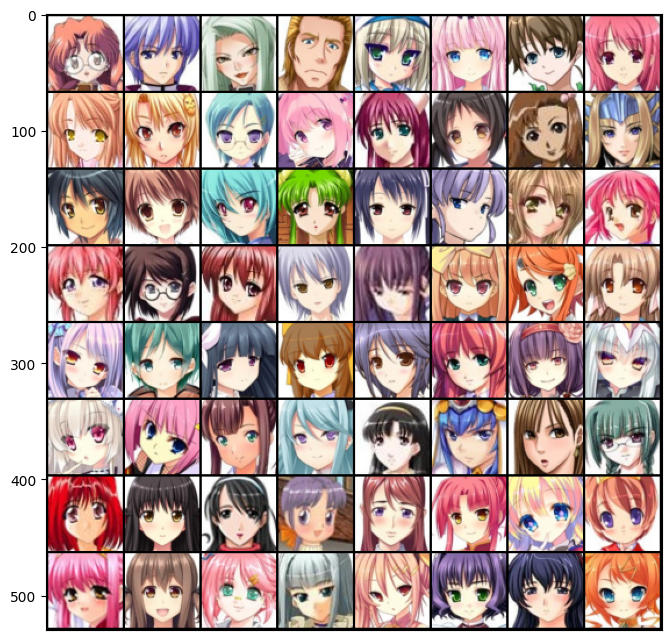

In [52]:
show_batch(trn_ldr)
trn_ldr = DeviceDataLoader(trn_ldr, device)

In [53]:
import torch.nn as nn 
discriminator = nn.Sequential(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(64),
                              nn.LeakyReLU(0.2, inplace=True),
                              ################################
                              nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(128),
                              nn.LeakyReLU(0.2, inplace=True),
                              ################################
                              nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(256),
                              nn.LeakyReLU(0.2, inplace=True),
                              ################################
                              nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(512),
                              nn.LeakyReLU(0.2, inplace=True),
                              ################################
                              nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
                              nn.Flatten(),
                              nn.Sigmoid())

In [54]:
discriminator = todevice(discriminator, device)

In [55]:
generator = nn.Sequential(nn.ConvTranspose2d(laten_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
                          nn.BatchNorm2d(512),
                          nn.ReLU6(True),
                          ################################
                          nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
                          nn.BatchNorm2d(256),
                          nn.ReLU6(True),
                          ################################
                          nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
                          nn.BatchNorm2d(128),
                          nn.ReLU6(True),
                          ################################
                          nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
                          nn.BatchNorm2d(64),
                          nn.ReLU6(True),
                          ################################
                          nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
                          nn.Tanh())

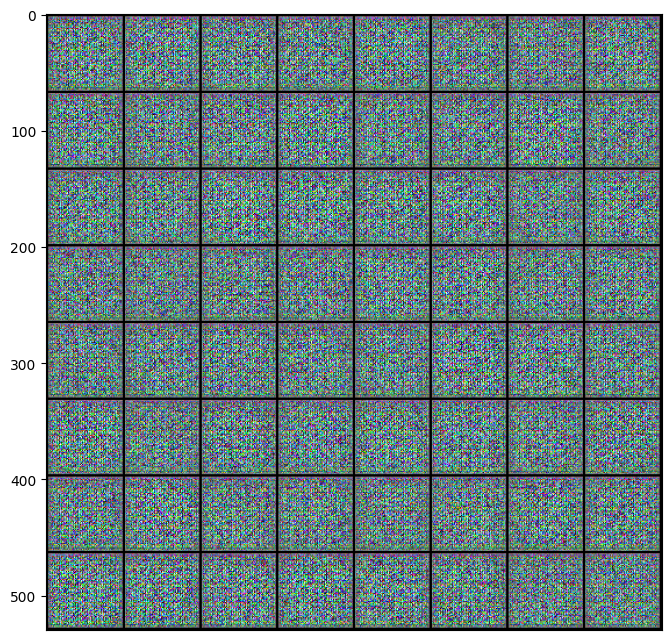

In [56]:
xb = torch.randn(bch_size, laten_size, 1, 1)
fake_img = generator(xb)
showimages(fake_img)

In [57]:
generator = todevice(generator, device)

In [58]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = nn.functional.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(bch_size, laten_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = nn.functional.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(bch_size, laten_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(bch_size, 1, device=device)
    loss = nn.functional.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [59]:
from torchvision.utils import save_image
sample_op_dir = './generated'

In [60]:
def save_examples(index, latent, show = True):
    fake_imgs = generator(latent)
    fake_name = '{0:0=4d}.png'.format(index)
    save_image(denorm(fake_imgs), os.path.join(sample_op_dir,fake_name), nrow=8)
    print('saving',fake_name)
    if show:
        fig, axis = plt.subplots(figsize=(8,8))
        axis.set_xticks([]),axis.set_yticks([])
        axis.imshow(make_grid(fake_imgs.cpu().detach(), nrow=8).permute((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saving 0000.png


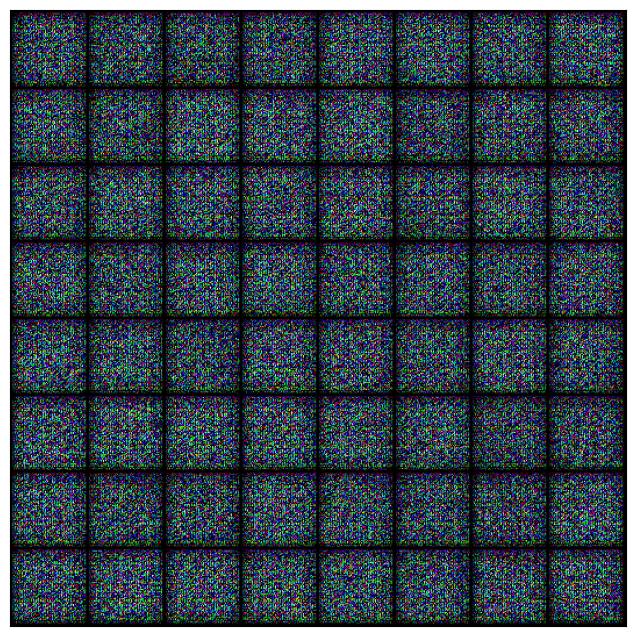

In [61]:
fixed_latent = torch.randn(64, laten_size, 1, 1, device=device)
save_examples(0, fixed_latent)

In [62]:
from tqdm.notebook import tqdm

In [63]:
def fit(epocs, lr, start_idx=1):
    torch.cuda.empty_cache()
    ################################
    loss_g = []
    loss_d = []
    real_scores = []
    fake_scores = []
    optm_d = torch.optim.Adam(discriminator.parameters(), lr=lr , betas=(0.5, 0.999))
    optm_g = torch.optim.Adam(generator.parameters(), lr=lr , betas=(0.5, 0.999))
    ################################
    for epoc in range(epocs):
        for real_imgs,___ in tqdm(trn_ldr):
            loss_d0 , real_score, fake_score = train_discriminator(real_imgs,optm_d)
            ################################
            loss_g0 = train_generator(optm_g)
        loss_g.append(loss_g0)
        loss_d.append(loss_d0)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        ################################
        print("Epoch"+str(epoc+1)+"_"+str(epoc)+" loss_g:"+str(loss_g)+", loss_d:" +str(loss_d)+", real_score: "+str(real_scores)+", fake_score:" +str(fake_scores))
        save_examples(epoc+start_idx, fixed_latent, show=False)
        ################################
    return loss_g, loss_d, real_scores, fake_scores

In [64]:
lr = 0.0002
epocs = 25

In [65]:
hist = fit(epocs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch1_0 loss_g:[4.1716508865356445], loss_d:[0.4410238564014435], real_score: [0.7988572716712952], fake_score:[0.14624248445034027]
saving 0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch2_1 loss_g:[4.1716508865356445, 4.603355407714844], loss_d:[0.4410238564014435, 0.28690305352211], real_score: [0.7988572716712952, 0.8137261271476746], fake_score:[0.14624248445034027, 0.0549803301692009]
saving 0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch3_2 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181]
saving 0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch4_3 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557]
saving 0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch5_4 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198]
saving 0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch6_5 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198, 0.3844885528087616]
saving 0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch7_6 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198, 0.3844885528087616, 0.28296443819999695]
saving 0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch8_7 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198, 0.3844885528087616, 0.28296443819999695, 0.0029903887771070004]
saving 0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch9_8 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198, 0.3844885528087616, 0.28296443819999695, 0.0029903887771070004, 0.008032099343836308]
saving 0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch10_9 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198, 0.3844885528087616, 0.28296443819999695, 0.0029903887771070004, 0.008032099343836308, 0.07892092317342758]
saving 0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch11_10 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368, 0.9983009099960327], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198, 0.3844885528087616, 0.28296443819999695, 0.0029903887771070004, 0.008032099343836308, 0.07892092317342758, 0.347615122795105]
saving 0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch12_11 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368, 0.9983009099960327, 0.9714846014976501], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198, 0.3844885528087616, 0.28296443819999695, 0.0029903887771070004, 0.008032099343836308, 0.07892092317342758, 0.347615122795105, 0.000228

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch13_12 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368, 0.9983009099960327, 0.9714846014976501, 0.7274465560913086], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198, 0.3844885528087616, 0.28296443819999695, 0.0029903887771070004, 0.00803209

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch14_13 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368, 0.9983009099960327, 0.9714846014976501, 0.7274465560913086, 0.9620345234870911], fake_score:[0.14624248445034027, 0.0549803301692009, 0.3029637634754181, 0.001320027164183557, 0.374675452709198, 0.38448855280

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch15_14 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368, 0.9983009099960327, 0.9714846014976501, 0.7274465560913086, 0.9620345234870911, 0.9809463024139404], fake_score:[0.14624248445034027, 0.0549803301692009, 0.302963763475

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch16_15 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368, 0.9983009099960327, 0.9714846014976501, 0.7274465560913086, 0.9620345234870911, 0.9809463024139404, 0.9856052398681641], fake_sc

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch17_16 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148, 4.928487777709961], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126, 0.11257975548505783], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368, 0.9983009099960327, 0.9714846014976501, 0.7274465560913086, 0.9620345234870911, 0.980946

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch18_17 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148, 4.928487777709961, 8.018308639526367], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126, 0.11257975548505783, 0.14171674847602844], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368, 0.9983009099960327, 0.9714846014976501, 0.727446

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch19_18 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148, 4.928487777709961, 8.018308639526367, 17.983070373535156], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126, 0.11257975548505783, 0.14171674847602844, 0.3856177031993866], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.8239885568618774, 0.8888345956802368, 0.998300

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch20_19 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148, 4.928487777709961, 8.018308639526367, 17.983070373535156, 7.279711723327637], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126, 0.11257975548505783, 0.14171674847602844, 0.3856177031993866, 0.05160428211092949], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.9994382858276367, 0.8990961313247681, 0.823988

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch21_20 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148, 4.928487777709961, 8.018308639526367, 17.983070373535156, 7.279711723327637, 6.727662086486816], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126, 0.11257975548505783, 0.14171674847602844, 0.3856177031993866, 0.05160428211092949, 0.06852772831916809], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.9914858937263489, 0.976819634437561, 0.999438

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch22_21 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148, 4.928487777709961, 8.018308639526367, 17.983070373535156, 7.279711723327637, 6.727662086486816, 6.052014350891113], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126, 0.11257975548505783, 0.14171674847602844, 0.3856177031993866, 0.05160428211092949, 0.06852772831916809, 0.06694517284631729], real_score: [0.7988572716712952, 0.8137261271476746, 0.9248645305633545, 0.5144608616828918, 0.99148

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch23_22 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148, 4.928487777709961, 8.018308639526367, 17.983070373535156, 7.279711723327637, 6.727662086486816, 6.052014350891113, 9.588581085205078], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126, 0.11257975548505783, 0.14171674847602844, 0.3856177031993866, 0.05160428211092949, 0.06852772831916809, 0.06694517284631729, 0.11093103140592575], real_score: [0.7988572716712952, 0.8137261271476746, 0.92486

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch24_23 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148, 4.928487777709961, 8.018308639526367, 17.983070373535156, 7.279711723327637, 6.727662086486816, 6.052014350891113, 9.588581085205078, 7.959961414337158], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126, 0.11257975548505783, 0.14171674847602844, 0.3856177031993866, 0.05160428211092949, 0.06852772831916809, 0.06694517284631729, 0.11093103140592575, 0.036521174013614655], real_score: [0.7988

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch25_24 loss_g:[4.1716508865356445, 4.603355407714844, 7.335598945617676, 4.479162216186523, 14.961919784545898, 12.163223266601562, 13.410714149475098, 6.68433952331543, 5.7812395095825195, 5.643422603607178, 17.510574340820312, 15.60426139831543, 5.483291149139404, 4.909013748168945, 6.276857376098633, 7.549871444702148, 4.928487777709961, 8.018308639526367, 17.983070373535156, 7.279711723327637, 6.727662086486816, 6.052014350891113, 9.588581085205078, 7.959961414337158, 7.596564292907715], loss_d:[0.4410238564014435, 0.28690305352211, 0.4963160455226898, 0.9604406356811523, 0.5561281442642212, 0.6027919054031372, 0.38150554895401, 0.1278447061777115, 0.2619926929473877, 0.2378809154033661, 0.7175245881080627, 0.03423449769616127, 0.48026832938194275, 0.058974336832761765, 0.06967630237340927, 0.02116779424250126, 0.11257975548505783, 0.14171674847602844, 0.3856177031993866, 0.05160428211092949, 0.06852772831916809, 0.06694517284631729, 0.11093103140592575, 0.036521174013614655, 0

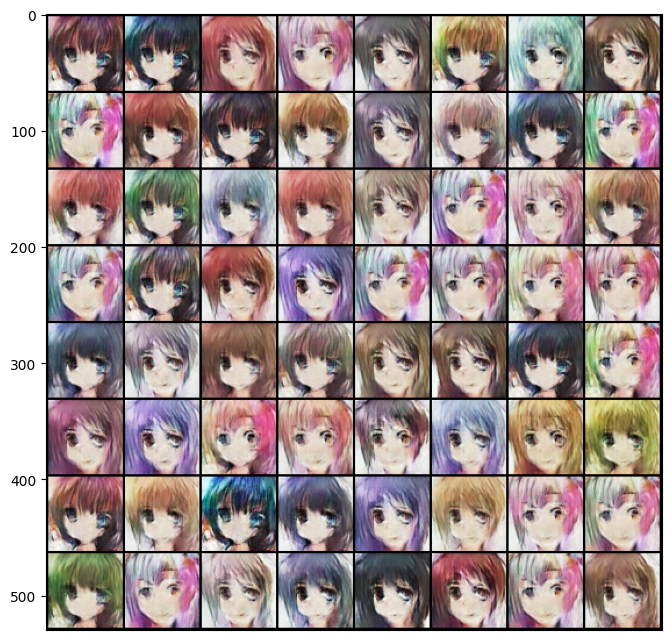

In [70]:
xb = torch.randn(bch_size, laten_size, 1, 1, device = device)
fake_img = generator(xb)
fake_img = fake_img.cpu()
showimages(fake_img)